# Diabetes Prediction - MLDA Final Project
Author: **Lorenzo La Corte** - S4784539

Dataset: **Diabetes Dataset, from the N. Inst. of Diabetes & Diges. & Kidney Dis.**

--------------------------------------------------------------------------------------------------------------------

## Main Goals of the Analysis

**Main Goal:**
The objective is to predict based on diagnostic measurements whether a patient has diabetes.

The first step will be eventually cleaning the dataset; once cleaned, I'll go further with an analysis that aims to spot the most relevant characteristics of the dataset, to make a more conscious and accurate model.

**Content and Features**
Several constraints were placed on the selection of these instances from a larger database. 
In particular, all patients here are females at least 21 years old of Pima Indian heritage.

The columns in the dataset are: 
- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration (2 hours oral glucose tolerance test)
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Class variable (0 or 1)

--------------------------------------------------------------------------------------------------------------------

## Index

* [0.) Preliminary Operations](#0)


* [1.) Feature Analysis](#1)


* [2.) Feature Engineering](#2)


* [3.) Outcome Prediction](#3)   


* [4.) Random Forest Tuning](#4)   


* [5.) Final Comments](#5)   

# 0. Preliminary Operations <a id='0'></a>

Import of fundamental libraries:

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import scipy.stats as stats
import scipy
import seaborn as sns
import math

Import of the dataset and visualization of the first rows:

In [2]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Visualization of the number of rows and columns:

In [3]:
print("(number of rows, number of columns): " + str(diabetes.shape))

(number of rows, number of columns): (768, 9)


## Cleaning of the Dataset

A quick sight of the dataset is enough to conclude that all the features are numeric.
Let's take a deeper look at them.

In [4]:
diabetes.describe().round(2).style.background_gradient()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.850000,120.890000,69.110000,20.540000,79.800000,31.990000,0.470000,33.240000,0.350000
std,3.370000,31.970000,19.360000,15.950000,115.240000,7.880000,0.330000,11.760000,0.480000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.240000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.370000,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.630000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


It seems the dataset has no missing values, but I'll make a further check on it:

In [5]:
print("Null Values:\n" + str(diabetes.isnull().sum()))
print("\nDuplicate Values: " + str(diabetes.duplicated().sum()))

Null Values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Duplicate Values: 0


The dataset:
- doesn't contain any missing values (all the columns have 768 values).
- doesn't contain duplicate rows.

Let's take a look at the distribution of values:

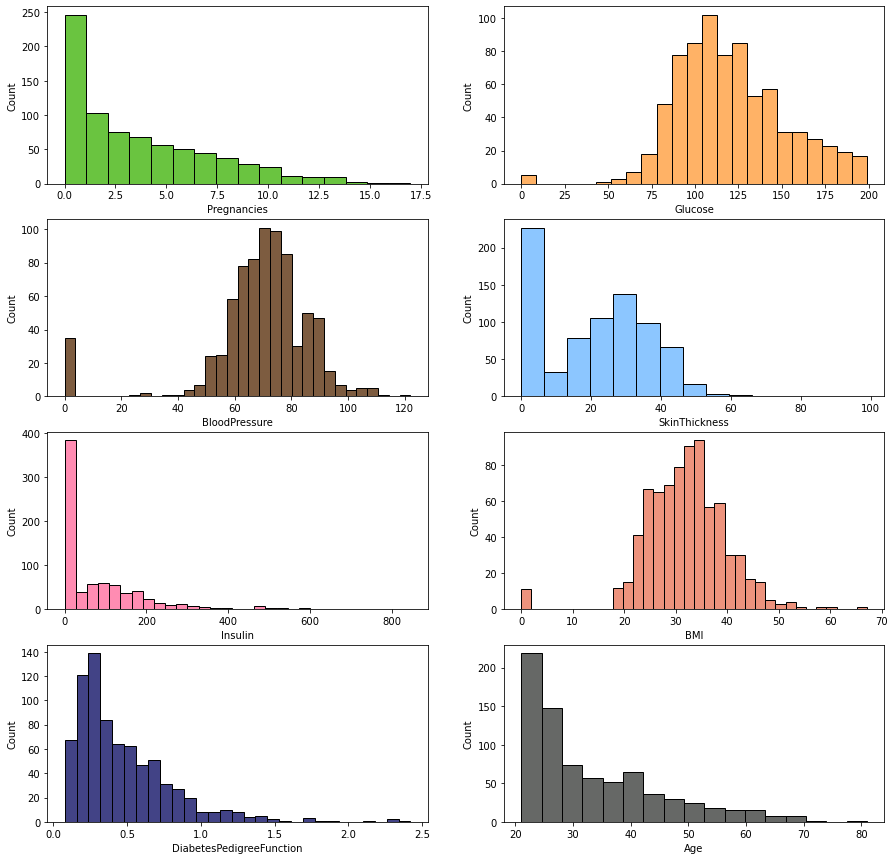

In [6]:
fig, axs = plt.subplots(4, 2, figsize=(15,15))
axs = axs.flatten()
sns.histplot(diabetes['Pregnancies'],color='#38b000',ax=axs[0])
sns.histplot(diabetes['Glucose'],color='#FF9933',ax=axs[1])
sns.histplot(diabetes['BloodPressure'],color='#522500',ax=axs[2])
sns.histplot(diabetes['SkinThickness'],color='#66b3ff',ax=axs[3])
sns.histplot(diabetes['Insulin'],color='#FF6699',ax=axs[4])
sns.histplot(diabetes['BMI'],color='#e76f51',ax=axs[5])
sns.histplot(diabetes['DiabetesPedigreeFunction'],color='#03045e',ax=axs[6])
sns.histplot(diabetes['Age'],color='#333533',ax=axs[7])
plt.show()

We can notice that many values are encoded as 0 in all features: they can invalidate our analysis and model.

I'll replace them with NaN values in order to count them:

In [7]:
cols = ["Glucose","BloodPressure","Insulin","SkinThickness","BMI"]
diabetes[cols] = diabetes[cols].replace(0,np.nan)
diabetes.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Dropping NaN values would mean losing half of the dataset, so I'll replace them with the median for their column:

In [8]:
# The missing values will be filled with the median values of each variable.
def median_target(var):   
    temp = diabetes[diabetes[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

# consider all columns except outcome
columns = diabetes.columns
columns = columns.drop("Outcome")

# The values to be given for incomplete observations are given the median value of people who are not sick and the median values of people who are sick.
for col in columns:
    diabetes.loc[(diabetes['Outcome'] == 0 ) & (diabetes[col].isnull()), col] = median_target(col)[col][0]
    diabetes.loc[(diabetes['Outcome'] == 1 ) & (diabetes[col].isnull()), col] = median_target(col)[col][1]
    
diabetes.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

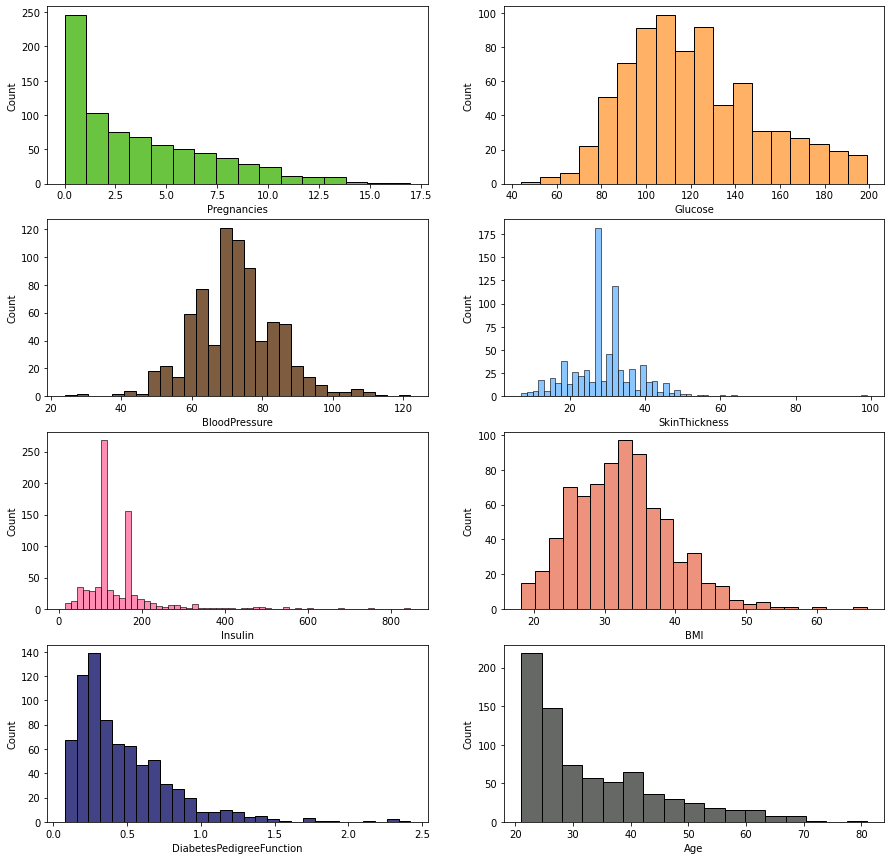

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(15,15))
axs = axs.flatten()
sns.histplot(diabetes['Pregnancies'],color='#38b000',ax=axs[0])
sns.histplot(diabetes['Glucose'],color='#FF9933',ax=axs[1])
sns.histplot(diabetes['BloodPressure'],color='#522500',ax=axs[2])
sns.histplot(diabetes['SkinThickness'],color='#66b3ff',ax=axs[3])
sns.histplot(diabetes['Insulin'],color='#FF6699',ax=axs[4])
sns.histplot(diabetes['BMI'],color='#e76f51',ax=axs[5])
sns.histplot(diabetes['DiabetesPedigreeFunction'],color='#03045e',ax=axs[6])
sns.histplot(diabetes['Age'],color='#333533',ax=axs[7])
plt.show()

# 1. Feature Analysis <a id='1'></a>

The main goal is to extract important pieces of information on the correlation between features. 

In [10]:
diabetes.corr().style.background_gradient(cmap="Blues")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.130155,0.209151,0.089028,0.058767,0.023890,-0.033523,0.544341,0.221898
Glucose,0.130155,1.000000,0.225141,0.229289,0.490015,0.236171,0.138353,0.268910,0.495990
BloodPressure,0.209151,0.225141,1.000000,0.199349,0.070128,0.286399,-0.001443,0.325135,0.174469
SkinThickness,0.089028,0.229289,0.199349,1.000000,0.200129,0.566086,0.106280,0.129537,0.295138
Insulin,0.058767,0.490015,0.070128,0.200129,1.000000,0.238443,0.146878,0.123629,0.377081
BMI,0.023890,0.236171,0.286399,0.566086,0.238443,1.000000,0.152771,0.027849,0.315577
DiabetesPedigreeFunction,-0.033523,0.138353,-0.001443,0.106280,0.146878,0.152771,1.000000,0.033561,0.173844
Age,0.544341,0.268910,0.325135,0.129537,0.123629,0.027849,0.033561,1.000000,0.238356
Outcome,0.221898,0.495990,0.174469,0.295138,0.377081,0.315577,0.173844,0.238356,1.000000


We can notice lots of correlations in the dataset; some are obvious (for example the one between Age and Pregnancies) but some are interesting.

We focus on the correlation with Outcome, which has:
- a **soft correlation with Pregnancies, Blood Pressure, DiabetesPedigreeFunction and Age**,
- a **correlation with Skin Thickness, Insulin and BMI**,
- a **strong correlation with Glucose**.

## Analysis on Outcome
In this analysis we focus on the Outcome and its correlation with other features.

------------------------------------------------------------------------------------------------------------------

Let's start seeing if the Outcome is balanced:

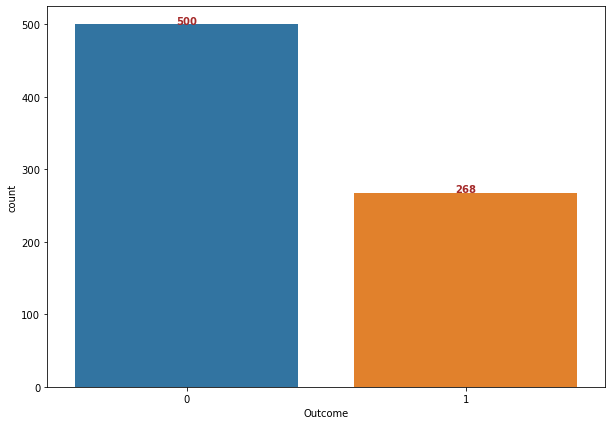

In [11]:
def countplot(data,x,w=10,h=7,hue=None,ax=None,order_desc= False):
    plt.figure(figsize=(w,h))
    ax = sns.countplot(data=data,x=x,hue=hue,ax=ax)
    if hue: plt.legend(labels = ['no diabete', 'diabete'])

    for patch in ax.patches:
        loc = patch.get_x()
        width = patch.get_width()
        height = patch.get_height() if not math.isnan(patch.get_height()) else 0        
        ax.text(loc+width/2,height,str(height),fontsize = 10,weight="bold",color='brown',ha = "center")

countplot(diabetes,"Outcome")

We can notice that the feature is unbalanced: there are much more non-sick cases.

------------------------------------------------------------------------------------------------------------------

### What's the relationship between Pregnancies and Outcome

Let's try to analyze the relationship between different features and Outcome, starting with the pregnancies.

C:\Users\loren\AppData\Local\Temp/ipykernel_4984/315430366.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  less_two_pregnant = diabetes[diabetes.Pregnancies > 0][diabetes.Pregnancies <= 2]


<AxesSubplot:title={'center':'>2 times Pregnant Outcome Distribution'}>

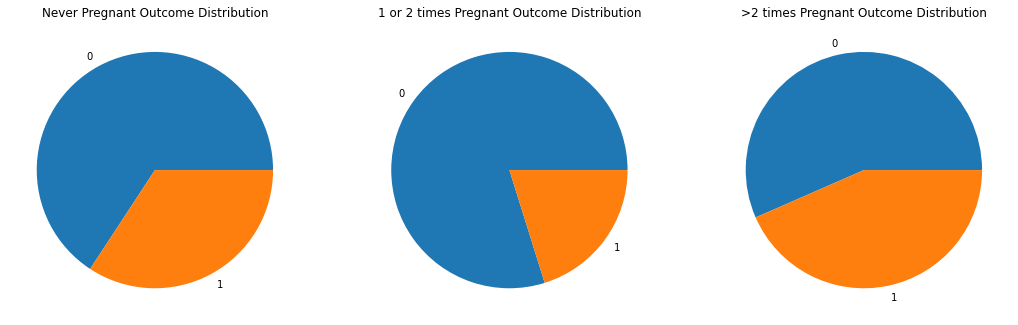

In [12]:
never_pregnant = diabetes[diabetes.Pregnancies == 0]
less_two_pregnant = diabetes[diabetes.Pregnancies > 0][diabetes.Pregnancies <= 2]
more_two_pregnant = diabetes[diabetes.Pregnancies > 2]

plt.subplot(1,3,1)
never_pregnant['Outcome'].value_counts().plot(kind='pie', figsize=(18,18), title=f'Never Pregnant Outcome Distribution', ylabel = '')
plt.subplot(1,3,2)
less_two_pregnant['Outcome'].value_counts().plot(kind='pie', figsize=(18,18), title=f'1 or 2 times Pregnant Outcome Distribution', ylabel = '')
plt.subplot(1,3,3)
more_two_pregnant['Outcome'].value_counts().plot(kind='pie', figsize=(18,18), title=f'>2 times Pregnant Outcome Distribution', ylabel = '')


It seems that women 1 or 2 times pregnant have less probability to have diabetes, while starting from 3 pregnancies the probability increases.

Let's look more in detail at all the classes of pregnancies:

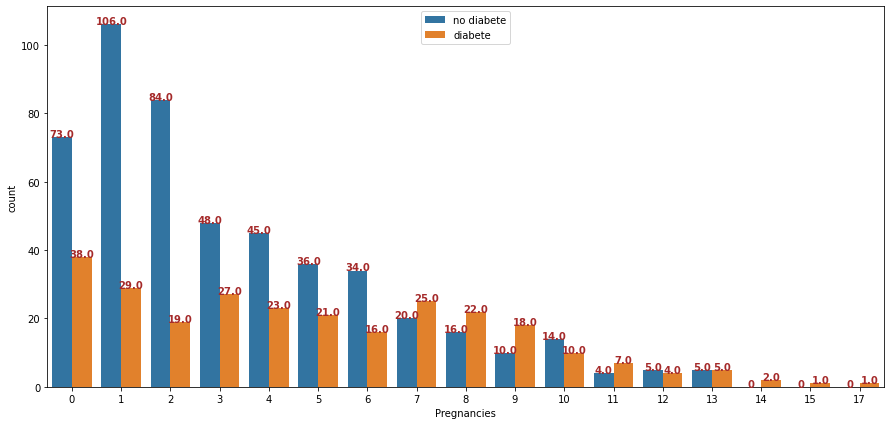

In [13]:
countplot(diabetes,"Pregnancies",15,7, hue="Outcome",order_desc= True)

It seems like the more pregnancy has a woman, the more is probable that she has diabetes.

------------------------------------------------------------------------------------------------------------------

### What's the relationship between Age and Outcome

Let's try to apply the same comparison with the features Age and Outcome:

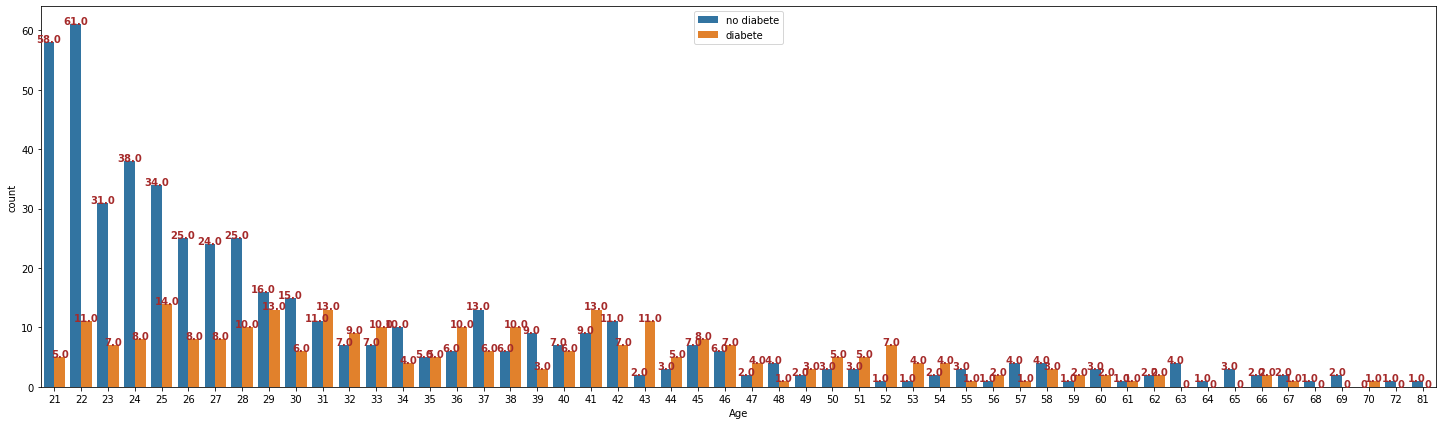

In [14]:
countplot(diabetes,"Age",25,7, hue="Outcome",order_desc= True)

The dataset contains more entries of young women. 

Also in this case, as the age of a woman increments, it increments the percentage of diabetes cases.

------------------------------------------------------------------------------------------------------------------

### What's the relationship between DiabetesPedigreeFunction and Outcome

Diabetes Pedigree Function indicates the function which scores the likelihood of diabetes based on family history.
Let's analyze the percentage of diabetes cases for the classes which contains a value under or over the mean for this metric.

<AxesSubplot:title={'center':'DPF greater than mean'}>

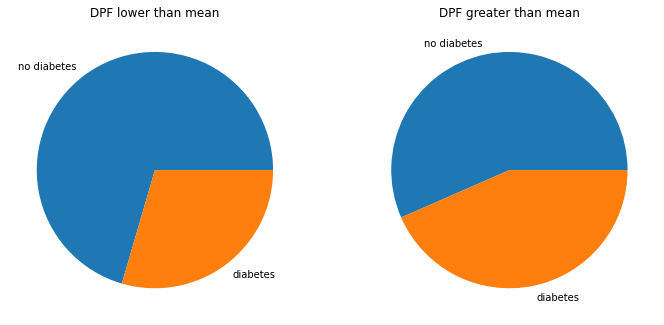

In [15]:
low_ped = diabetes[diabetes.DiabetesPedigreeFunction < 0.47]
high_ped = diabetes[diabetes.DiabetesPedigreeFunction >= 0.47]

plt.subplot(1,3,1)
low_ped['Outcome'].value_counts().plot(kind='pie', labels=['no diabetes','diabetes'],figsize=(18,18), title=f'DPF lower than mean', ylabel = '')
plt.subplot(1,3,2)
high_ped['Outcome'].value_counts().plot(kind='pie', labels=['no diabetes','diabetes'], figsize=(18,18), title=f'DPF greater than mean', ylabel = '')

As expected, the higher the DPF, the more probable is the woman to have diabete.


------------------------------------------------------------------------------------------------------------------

### What's the relationship between Insulin and Glucose and Outcome

Text(0, 0.5, 'Glucose')

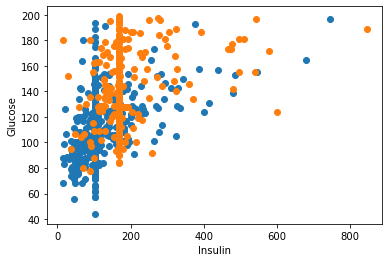

In [16]:
import matplotlib.pyplot as ppt

healthy = diabetes[diabetes.Outcome == 0]
sick = diabetes[diabetes.Outcome == 1]

ppt.scatter(healthy.Insulin, healthy.Glucose)
ppt.scatter(sick.Insulin, sick.Glucose)
ppt.xlabel('Insulin')
ppt.ylabel('Glucose')

# 2. Feature Engineering <a id='2'></a>

Let's do some feature engineering in order to get a more accurate model.
We need to create new features based on real knowledge about diabete.

The goal is to **classify BMI, Glucose, Blood Pressure and Skin Thickness**.

In [17]:
NewCols = ["NewBMI", "NewGlucose", "NewBP", "NewTSF"]

------------------------------------------------------------------------------------------------------------------

### BMI

Let's start with the BMI, which can produce six classes based on the content of this article: https://www.cdc.gov/obesity/basics/adult-defining.html

In [18]:
NewBMI_list = ["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"]
NewBMI = pd.Series(NewBMI_list, dtype = "category")

diabetes["NewBMI"] = NewBMI

diabetes.loc[diabetes["BMI"] < 18.5, "NewBMI"] = NewBMI[0]
diabetes.loc[(diabetes["BMI"] > 18.5) & (diabetes["BMI"] <= 24.9), "NewBMI"] = NewBMI[1]
diabetes.loc[(diabetes["BMI"] > 24.9) & (diabetes["BMI"] <= 29.9), "NewBMI"] = NewBMI[2]
diabetes.loc[(diabetes["BMI"] > 29.9) & (diabetes["BMI"] <= 34.9), "NewBMI"] = NewBMI[3]
diabetes.loc[(diabetes["BMI"] > 34.9) & (diabetes["BMI"] <= 39.9), "NewBMI"] = NewBMI[4]
diabetes.loc[diabetes["BMI"] > 39.9 ,"NewBMI"] = NewBMI[5]

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,Overweight
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity 3


We have now classified the BMI feature.

------------------------------------------------------------------------------------------------------------------

### Glucose

The following knowledge is based on the article: https://diabetes.org/diabetes/a1c/diagnosis

The level of glucose in the dataset refers to an Oral Glucose Tolerance Test (OGTT), a two-hour test that checks your blood glucose levels before and two hours after you drink a special sweet drink. It tells the doctor how your body processes sugar.

**Diabetes is diagnosed at two-hour blood glucose of greater than or equal to 200 mg/dl**, so this feature may be crucial to classify diabete cases.

In [19]:
NewGlucose_list = ["Normal", "Prediabetes", "Diabetes"]
NewGlucose = pd.Series(NewGlucose_list, dtype = "category")

diabetes["NewGlucose"] = NewGlucose

diabetes.loc[diabetes["Glucose"] <= 140, "NewGlucose"] = NewGlucose[0]

diabetes.loc[(diabetes["Glucose"] > 140) & (diabetes["Glucose"] <= 199), "NewGlucose"] = NewGlucose[1]

diabetes.loc[diabetes["Glucose"] > 199 ,"NewGlucose"] = NewGlucose[2]

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewGlucose
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1,Prediabetes
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,Overweight,Normal
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal,Prediabetes
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight,Normal
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity 3,Normal


------------------------------------------------------------------------------------------------------------------

### Blood Pressure

Knowledge is achieved through this article: https://www.cdc.gov/bloodpressure/about.htm.

Blood pressure can be classified as:
- Normal, diastolic: less than 80 mm Hg
- At Risk (prehypertension) diastolic: 80–89 mm Hg
- High Blood Pressure (hypertension) diastolic: 90 mm Hg or higher


In [20]:
NewBP_list = ["Normal", "Prehypertension", "Hypertension"]
NewBP = pd.Series(NewBP_list, dtype = "category")

diabetes["NewBP"] = NewBP

diabetes.loc[diabetes["BloodPressure"] <= 80, "NewBP"] = NewBP[0]

diabetes.loc[(diabetes["BloodPressure"] > 80) & (diabetes["BloodPressure"] <= 89), "NewBP"] = NewBP[1]

diabetes.loc[diabetes["BloodPressure"] > 89 ,"NewBP"] = NewBP[2]

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewGlucose,NewBP
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1,Prediabetes,Normal
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,Overweight,Normal,Normal
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal,Prediabetes,Normal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight,Normal,Normal
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity 3,Normal,Normal


------------------------------------------------------------------------------------------------------------------

### SkinThickness

Source: www.frontiersin.org/articles/10.3389/fcvm.2022.858994/full#:~:text=In%20the%20study%20population%2C%20the,vs%2014.3%20%C2%B1%206.8%20mm

Women have much higher TSF thickness than men, the normal range is 23.6 ± 7.5 mm (for men is 14.3 ± 6.8 mm). 

In [21]:
NewTSF_list = ["Normal", "Abnormal"]
NewTSF = pd.Series(NewTSF_list, dtype = "category")

diabetes["NewTSF"] = NewTSF

diabetes.loc[(diabetes["SkinThickness"] >= 16.1) & (diabetes["SkinThickness"] <= 31.1), "NewTSF"] = NewTSF[0]

diabetes.loc[(diabetes["SkinThickness"] < 16.1) | (diabetes["SkinThickness"] > 31.1), "NewTSF"] = NewTSF[1]

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewGlucose,NewBP,NewTSF
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1,Prediabetes,Normal,Abnormal
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,Overweight,Normal,Normal,Normal
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal,Prediabetes,Normal,Abnormal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight,Normal,Normal,Normal
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity 3,Normal,Normal,Abnormal


------------------------------------------------------------------------------------------------------------------

#### Convert classes into columns
This process aims to develop columns that can be used to increment the prediction's accuracy.

In [22]:
categorical_df = pd.get_dummies(diabetes, columns = ["NewBMI", "NewGlucose", "NewBP", "NewTSF"], drop_first = True)
categorical_df = categorical_df.drop(diabetes.columns, axis=1, errors='ignore')
categorical_df.head()

,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewGlucose_Normal,NewGlucose_Prediabetes,NewBP_Normal,NewBP_Prehypertension,NewTSF_Normal
0,1,0,0,0,0,0,1,1,0,0
1,0,0,0,1,0,1,0,1,0,1
2,0,0,0,0,0,0,1,1,0,0
3,0,0,0,1,0,1,0,1,0,1
4,0,0,1,0,0,1,0,1,0,0


# 3. Outcome Prediction <a id='3'></a>
## Supervised Learning

**Main Goal:** Observe the comparison between multiple algorithms which have the same objective: predict the outcome based on the other features.

We will separate this part into two phases:
- algorithm analysis comparison,
- tuning of one of the algorithms, in order to get the best results out of it. 

In [23]:
from sklearn.preprocessing import scale, StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_validate

## Algorithm Comparison

The objective now is to test some possible algorithms which predict the Outcome for a given patient. 

------------------------------------------------------------------------------------------------------------------

The dataset is preprocessed: 

In [43]:
y = diabetes["Outcome"]
X = diabetes.drop(["Outcome"]+NewCols, axis = 1)
cols = X.columns
index = X.index

transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)
X = pd.concat([X, categorical_df], axis = 1)
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewGlucose_Normal,NewGlucose_Prediabetes,NewBP_Normal,NewBP_Prehypertension,NewTSF_Normal
0,0.6,0.765432,0.000,1.000000,1.000000,0.170330,0.665359,1.235294,1,0,0,0,0,0,1,1,0,0
1,-0.4,-0.790123,-0.375,0.142857,0.000000,-0.598901,-0.056209,0.117647,0,0,0,1,0,1,0,1,0,1
2,1.0,1.629630,-0.500,0.571429,1.000000,-0.961538,0.783007,0.176471,0,0,0,0,0,0,1,1,0,0
3,-0.4,-0.691358,-0.375,-0.714286,-0.126866,-0.434066,-0.537255,-0.470588,0,0,0,1,0,1,0,1,0,1
4,-0.6,0.493827,-2.000,1.000000,0.977612,1.214286,5.007843,0.235294,0,0,1,0,0,1,0,1,0,0


------------------------------------------------------------------------------------------------------------------

The **selected algorithms** are:
- Logistic Regression
- k-nearest neighbors classifier
- Random Forest Classifier
- SVC

#### Logistic Regression

Logistic regression is a statistical analysis method to predict a binary outcome based on prior observations of a data set.

A logistic regression model predicts a dependent data variable by analyzing the relationship between one or more existing independent variables. 
Based on historical data about earlier outcomes involving the same input criteria, it then scores new cases on their probability of falling into one of two outcome categories.

#### k-nearest neighbors classifier
KNN algorithm is a simple, easy-to-implement supervised machine learning algorithm that can be used to solve both classification and regression problems; it's used in pattern recognition for the classification of objects based on the characteristics of the objects close to the one considered.

KNN for classification works by **finding the distances between a query and all the examples in the data**, selecting the specified number of examples (K) closest to the query, and then voting for the most frequent label. 

Have to find the right K we run the KNN algorithm several times with different values of K and **choose the K that reduces the number of errors**:
- As we decrease the value of K to 1, our predictions become less stable (warning of **overfitting**). 
- As we increase the value of K, our predictions become more stable due to majority voting, and thus, more likely to make more accurate predictions, but if we begin to see an increasing number of errors (warning of **underfitting**): it is at this point that we know we have pushed the K value too far. 

The main advantages are: 
- The algorithm is simple and easy to implement. There’s no need to build a model, tune several parameters, or make additional assumptions. 
- The algorithm is versatile. It can be used for classification, regression, and search (as we will see in the next section). 
But: the algorithm gets significantly slower as the number of examples and/or predictors/independent variables increase.

#### Random Forest Classifier
Random forest is a learning method for classification and regression that **operates by constructing a multitude of decision trees at training time**.

A decision tree is a graph of decisions and their possible consequences: 
- each internal node represents a variable, 
- an arc towards a child node represents a possible value for that property,
- a leaf represents the predicted value for the target variable starting from the values of the other properties, which in the tree is represented by the path from the root node to the leaf node.

Random forests generally outperform decision trees because it consists of a large number of individual decision trees that operate as an ensemble:
- each individual tree in the random forest spits out a class prediction,
- the class with the most votes becomes our model’s prediction. 

A large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models, indeed **the low correlation between models is the key**. 

To do that we use **Bootstrap** to create many datasets, each one different from the other and, through Random Subset Feature Selection, we create the decision tree. This will allow us to create them on slightly different datasets and therefore we will have different trees, which however learn something from our dataset. Every single tree is not that good, but together I get  high accuracy. Furthermore, this type of model can be created in parallel.

For classification tasks, the output of the random forest is the class selected by most trees.

#### SVC

A support vector machine (SVM) is a supervised machine learning model that uses classification algorithms for two-group classification problems. After giving an SVM model a set of labeled training data for each category, they’re able to categorize new text.

Compared to newer algorithms like neural networks, they have two main advantages: 
- higher speed,
- better performance with a limited number of samples (in the thousands). 

A support vector machine **takes data points and outputs the hyperplane that best separates the tags**. 
The hyperplane **is the decision boundary**: anything that falls to one side of it we will classify as blue, and anything that falls to the other as red.

The best hyperplane for SVM it’s the one that maximizes the margins from both tags: the hyperplane whose distance to the nearest element of each tag is the largest.

In [44]:
SEED = 12345

models = []
models.append(('LR', LogisticRegression(random_state = SEED)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier(random_state = SEED)))
models.append(('SVM', SVC(gamma='auto', random_state = SEED)))

------------------------------------------------------------------------------------------------------------------

### Cross Validation
Data is usually divided into training and validation sets; cross-validation consists in:
- splitting the data into k bins,
- run k separate experiments, where each:
    - uses k-1 bins as training set,
    - uses the other remaining bin as validation set,
    - train the model.
- then average the test results from those k esperiments.

Doing so, we used all our data for training and testing; the only con of this method is that requires more computational time.

*KFold* and *cross_val_score* functions implement this concept.

------------------------------------------------------------------------------------------------------------------

### *KFold*
Is a cross-validator function that provides train/test indices to split data in train/test sets. 

In particular, it splits the dataset into k consecutive folds (without shuffling by default).

Each fold is then used once as validation while the k - 1 remaining folds form the training set.

------------------------------------------------------------------------------------------------------------------

### *cross_validate*
Evaluate a score by cross-validation, which has the following arguments:

- estimator: The object to use to fit the data, in our case the model used.

- X: The data to fit. 

- y: The target variable to try to predict in the case of supervised learning.

- cv: **Cross-validation splitting strategy**: in this case, the output of the KFold function.

- scoring: metrics to evaluate.

#### Metrics

- **Balanced Accuracy**: This metric is similar to accuracy, but it takes into account the imbalance in the dataset by calculating the average of recall for each class. This gives a more complete picture of the model's performance for datasets where one class is more important or overrepresented.

- **ROC AUC** (Receiver Operating Characteristic Area Under the Curve): This metric is used to evaluate the performance of binary classification models. It is the area under the ROC curve, which plots the true positive rate against the false positive rate. A higher ROC AUC score indicates that the model is better at distinguishing between positive and negative cases.

- **Recall**: This metric is also known as sensitivity or the true positive rate. It is the number of true positive predictions divided by the sum of the true positive predictions and false negative predictions. Recall is an important metric when it is important to minimize the number of false negatives, such as in medical diagnosis or fraud detection.

- **F1 Score**: This is the harmonic mean of precision and recall, and it is often used when there is a need to balance the trade-off between precision and recall. The F1 score takes both false positives and false negatives into account, making it a more comprehensive measure of performance in situations where it's important to avoid both types of errors.

In [45]:
SPLITS = 10

names = []

metrics = {'balanced_accuracy': 'balanced_accuracy',
           'roc_auc': 'roc_auc',
           'recall': 'recall',
           'f1': 'f1'}

results =  {'balanced_accuracy': [],
            'roc_auc': [],
            'recall': [],
            'f1': []}


for name, model in models:
    kfold = KFold(n_splits = SPLITS)

    cv_results = cross_validate(model, X, y, cv = kfold, scoring= metrics)
    
    names.append(name)
    
    print(name)
    for metric in metrics.keys():
        array_converted = [float(x) for x in cv_results['test_'+metric]]
        results[metric].append(array_converted)    
        print("%s: %f" % (metric, sum(array_converted)/len(array_converted)))
    print('\n')

LR
balanced_accuracy: 0.766809
roc_auc: 0.873423
recall: 0.659769
f1: 0.689842


KNN
balanced_accuracy: 0.806413
roc_auc: 0.887315
recall: 0.735024
f1: 0.746809


RF
balanced_accuracy: 0.853605
roc_auc: 0.935069
recall: 0.804767
f1: 0.808100


SVM
balanced_accuracy: 0.828083
roc_auc: 0.902685
recall: 0.763928
f1: 0.770827




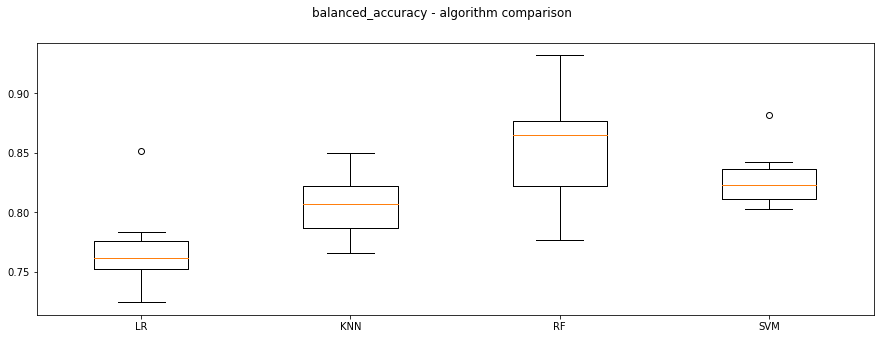

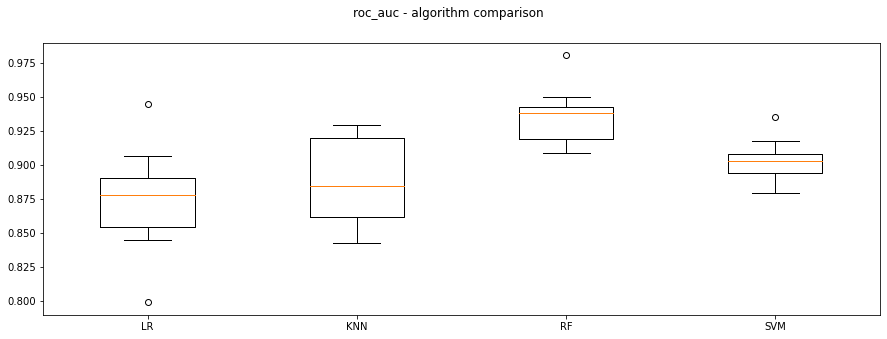

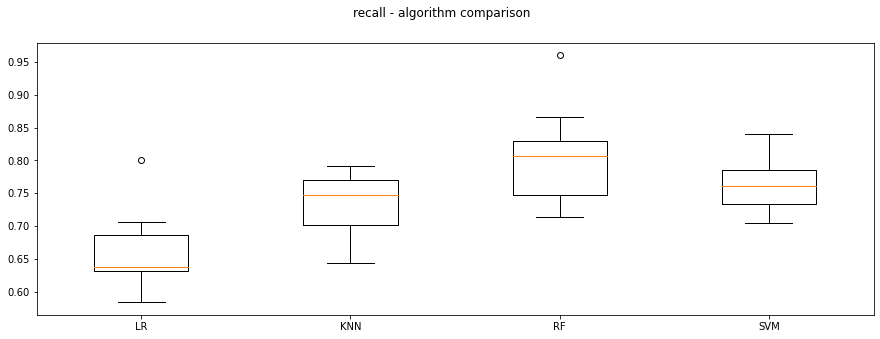

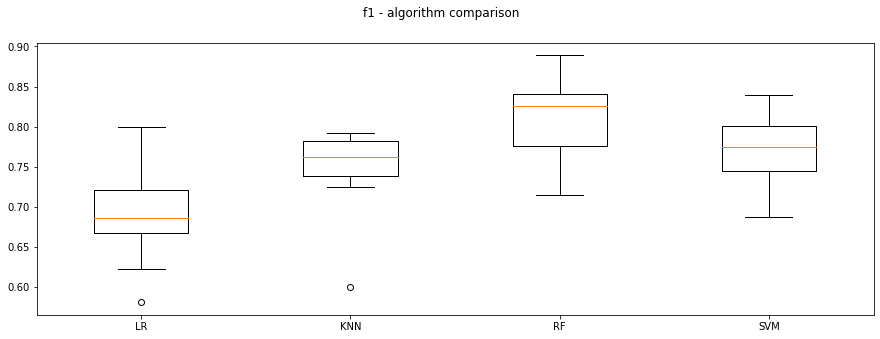

In [46]:
for metric in metrics.keys():
    # boxplot algorithm comparison
    fig = plt.figure(figsize=(15,5))
    fig.suptitle(metric + ' - algorithm comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results[metric])
    ax.set_xticklabels(names)
    plt.show()

**Random forest is the model with the best results**, followed by SVM, KNN and then LR.

It achieved a high level of accuracy and balanced accuracy.
The ROC/AUC score is also quite high, which indicates that the model is capable of differentiating between positive and negative cases in a reliable way. 
The recall score indicates that the model is able to correctly identify positive cases with a relatively high frequency.

Let's see how much its accuracy can be incremented by its tuning.

------------------------------------------------------------------------------------------------------------------

## 4. Random Forests Tuning <a id='4'></a>
This model is the chosen one for tuning because of its good results and its properties.

As a matter of fact, this learning algorithm is often used in medical datasets due to its several advantages:

1. **Handle missing values**: Random forests can handle missing values in the dataset without requiring imputation, making it suitable for datasets with missing data, which is common in medical data.

2. **Model interpretability**: The decision trees that make up a random forest can provide some level of interpretability, which is important for medical applications where understanding why a particular decision was made is critical.

3. **Ability to handle non-linear relationships**: Random forests can handle non-linear relationships between features, which is important in medical datasets where there can be complex relationships between variables.

4. **Robust to overfitting**: Random forests are less likely to overfit the data compared to decision trees, which is critical in medical applications, where the model needs to generalize well to new data.

------------------------------------------------------------------------------------------------------------------

#### GridSearchCV
GridSearchCV is used to perform **hyperparameter tuning**. The function takes in a machine learning model, a set of hyperparameters to search over, and a scoring metric. 

It then performs a **brute-force search** over the hyperparameter space, training and evaluating the model for each combination of hyperparameters.

The main idea is to **automate the process of hyperparameter tuning**, so that you don't have to manually try out different combinations of hyperparameters. Instead, you specify the hyperparameters you want to search over, and the function will try out all possible combinations and return the best set of hyperparameters based on the scoring metric you specified.

- n_estimators = number of trees in the forest
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node

In [47]:
# Number of trees in random forest
n_estimators = [100, 500, 1000]
# Number of features to consider at every split
max_features = [2, 5, 7]
# Maximum number of levels in tree
max_depth = [None, 5, 25]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5, 15]
# Create the random grid
rf_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(rf_params)

{'n_estimators': [100, 500, 1000], 'max_features': [2, 5, 7], 'max_depth': [None, 5, 25], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 5, 15]}


In [29]:
rf_model = RandomForestClassifier(random_state = SEED)

gs_cv = GridSearchCV(rf_model, 
                    rf_params,
                    cv = kfold,
                    n_jobs = -1,
                    verbose = 2).fit(X, y)

gs_cv.best_params_

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


{'max_depth': None,
 'max_features': 7,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 500}

The best parameters are so identified and the next step is to try the accuracy of RF with them.

------------------------------------------------------------------------------------------------------------------

The model is trained again with the **best parameters** and, again, **cross-validation**.

balanced_accuracy: 0.870398
roc_auc: 0.942541
recall: 0.834791
f1: 0.824747


C:\Users\loren\AppData\Local\Temp/ipykernel_4984/3615334196.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(names)


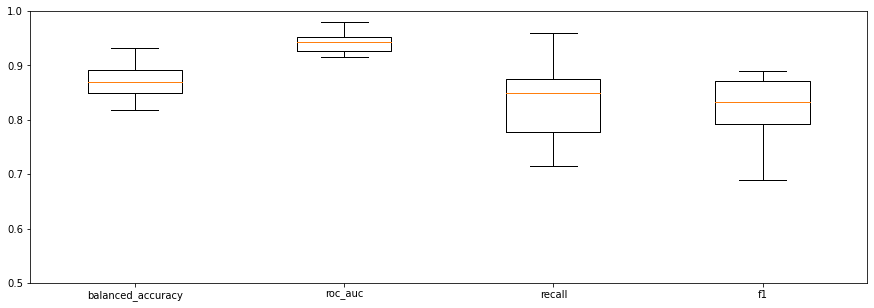

In [48]:
rf_tuned = RandomForestClassifier(**gs_cv.best_params_)
rf_tuned = rf_tuned.fit(X,y)

results = []
names = []

final_results = cross_validate(rf_tuned, X, y, cv = kfold, scoring= metrics)
for metric in metrics.keys():
    array_converted = [float(x) for x in final_results['test_'+metric]]
    print("%s: %f" % (metric, sum(array_converted)/len(array_converted)))
    results.append(array_converted)    
    names.append(metric)

# boxplot metrics comparison
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.set_xticklabels(names)
ax.set_ylim([0.5,1])
plt.boxplot(results)
plt.savefig("Boxplot Metrics - With Insulin", bbox_inches='tight', dpi=300)

The **score of all metrics increased**, but not significantly.

------------------------------------------------------------------------------------------------------------------

It's also possible to analyze **Variables' Severity Levels**, in fact, not all variables are equally important in making  predictions, and also in this case some variables had more impact on the outcome than others.

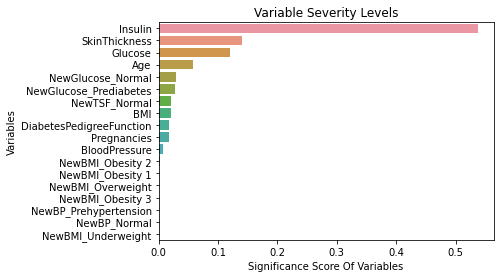

In [49]:
feature_imp = pd.Series(rf_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.savefig("Variable Severity Levels - With Insulin", bbox_inches='tight', dpi=300)

The most important features for predicting diabete are Insulin, Skin Thickness, Glucose, Age and BMI, Pregnancies and Blood Pressure; also some features coming from FE contributed to the scoring of RF, which are the ones classifying Glucose and TSF.

------------------------------------------------------------------------------------------------------------------

## Outcome Prediction without Insulin

The last experiment I would like to do is to erase Insulin feature from the dataset and analyse its impact.

In [40]:
y = diabetes["Outcome"]
X = diabetes.drop(["Outcome"]+NewCols+["Insulin"], axis = 1)
cols = X.columns
index = X.index

transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)
X = pd.concat([X, categorical_df], axis = 1)

rf_model = RandomForestClassifier(random_state = SEED)

gs_cv = GridSearchCV(rf_model, 
                    rf_params,
                    cv = kfold,
                    n_jobs = -1,
                    verbose = 2).fit(X, y)

gs_cv.best_params_

{'max_depth': None,
 'max_features': 7,
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 1000}

balanced_accuracy: 0.802558
roc_auc: 0.890795
recall: 0.709117
f1: 0.744627


C:\Users\loren\AppData\Local\Temp/ipykernel_4984/1174244116.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(names)


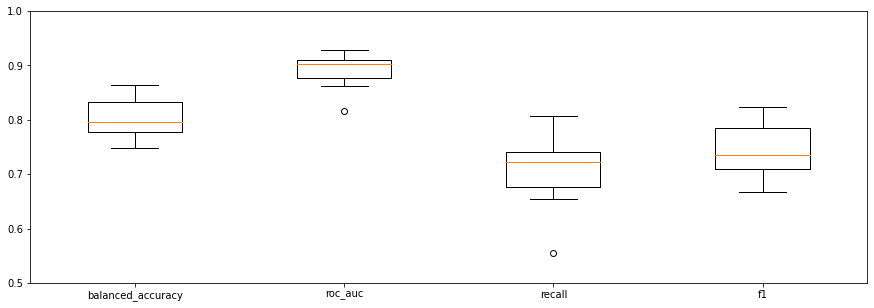

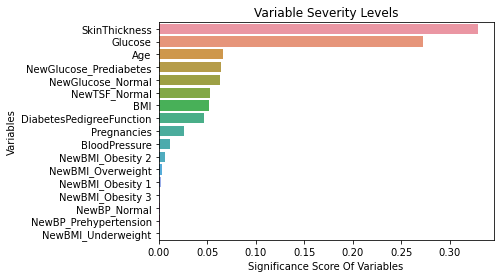

In [41]:
results = []
names = []

rf_tuned = RandomForestClassifier(**gs_cv.best_params_)
rf_tuned = rf_tuned.fit(X,y)
cv_results = cross_validate(rf_tuned, X, y, cv = 10, scoring= metrics)

for metric in metrics.keys():
    array_converted = [float(x) for x in cv_results['test_'+metric]]
    results.append(array_converted)    
    print("%s: %f" % (metric, sum(array_converted)/len(array_converted)))
    names.append(metric)

# boxplot algorithm comparison
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.set_xticklabels(names)
ax.set_ylim([0.5,1])
plt.boxplot(results)
plt.savefig("Boxplot Metrics - Without Insulin", bbox_inches='tight', dpi=300)
plt.show()

feature_imp = pd.Series(rf_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.savefig("Variable Severity Levels - Without Insulin", bbox_inches='tight', dpi=300)

Metrics' score diminuished roughly by 5-10%, the impact of features on the prediction is more balanced.

------------------------------------------------------------------------------------------------------------------

# 5. Final Comments <a id='5'></a>
- 1) A first analysis shows that **many columns of the dataset have a correlation with the Outcome**: analyzing some of them can reveal the relationship between this feature and the probability of having diabete for a woman.

------------------------------------------------------------------------------------------------------------------

- 2) The algorithm which has the best results is **Random Forest**.

------------------------------------------------------------------------------------------------------------------

- 3) **Random Forest tuning** doesn't increment significatively the accuracy of the model.

------------------------------------------------------------------------------------------------------------------

- 4) The five most important features for predicting diabete are **Insulin, Glucose, Skin Thickness, Age and BMI**.